# Analyse images on CloudObjectStorage using Mathematical Morphology methods in openCV


**Mathematical Morphology (MM) is a technique based on set theory to analyse structures in images**. It is different from other image processing methods in that it operates with entities like 'connected components', 'neighborhoods' or 'structural elements' as opposed to e.g. color, sharpness or frequency. Several implementations of MM exist, including the Matlab &trade; Image Processing Library and the python skimage morphology libraries. In this notebook the python interface to the 'openCV' open source library will be used on images that reside in DSX on Cloud Object Storage.

The application presented is designed to **help the barista optimize the coffee brewing process by measuring the size distribution of the coffee grind particles**. The coffee brewing process is influenced by several factors, including brewing time, water pressure and temperature and the coffee grind size. The latter is mutually adjusted with the others to find the sweet spot of perfect taste for a given coffee bean roast and brewing technology (see e.g. [coffee-grind-chart-1](https://www.homegrounds.co/coffee-grind-chart) or [coffee-grind-chart-2](https://ineedcoffee.com/coffee-grind-chart)). The **input data is an image of suitably prepared coffee grind taken using a low magnification microscope**. MM operations including erosion, dilation, opening, closing, tophat, geodesic distance and waterfall transform are used to identify and isolate grind particles such that their size in terms of pixels can be measured.

This notebook **requires a basic understanding of python and the DSX environment**. Some prior knowledge about MM is required to fully understand the operations employed, but the many plots of intermediate processing results should provide a general idea of the power of a MM pipeline. No introduction to MM will be given as many good resources can be found on the web. DSX Cloud Object Storage is used to store the images being analyzed. The MM part of code has been developed and tested in Spider 3.2 running Python 3.6. This Jupyter Notebook has been created and run on DSX with kernel Python 3.5 and Spark 2.1 employing opencv-python Version 3.4. in 05/2018.

## Table of Contents


**[1. Installation of python libraries and access to storage on DSX](#1)**<br>
[1.1. Installation of openCV and libraries for image processing](#1.1)<br>
[1.2. Access data on IBM Cloud Object Storage (COS)](#1.2)<br>
[1.3. Insert DSX credentials](#1.3)


**[2. Read image from Cloud Object Storage](#2)**<br>
[2.1. Establish connection to COS](#2.1)<br>
[2.2. Read image as stream from COS into ndarray](#2.2)<br>
[2.3. Write image in ndarray as stream to COS](#2.3)<br>
[2.4. Plot the CoffeeGrind sample image](#2.4)

**[3. The CoffeeGrindSieve](#3)**<br>
[3.1. Fundamental MM operations](#3.1)<br>
[3.2. Convert rgb to grayscale](3.2)<br>
[3.3. The grayscale image as digital elevation model (DEM)](#3.3)<br>
[3.4. Initial image cleaning](#3.4)<br>
[3.5. Flatten non-uniform lightning of background](#3.5)<br>
[3.6. Classification of pixels into coffee grind and background](#3.6)<br>
[3.7. Final classification mask](#3.7)<br>
[3.8. Isolation of coffee grind particles](#3.8)<br>
[3.9. Segment the watershed transform to segment the coffe grind into particles](#3.9)<br>
[3.10 Calculate the size of coffee grind particles](#3.10)

**[4. Discussion and outlook](#4)**<br>
[4.1. Critical Parameters](#4.1)<br>
[4.2. Image acquistion process](#4.2)<br>
[4.3. Advanced segmentation](#4.3)

**[5. Summary](#5)**<br>
[5.1. References](#5.1)<br>


<a id='1'></a>
## 1. Installation of python libraries and access to storage on DSX

openCV is usually not part of python or a distribution like e.g. Anaconda, so these libs need to be installed before importing.

Access to files on IBM Cloud Object Storage (or any other cloud storage service) is different from e.g. accessing files on local hard disk in that first a connection to the storage service must be established and then the actual transfer of image data initiated. These operations require the ibm_boto3 library and credentials provided by DSX.

<div class="alert alert-block alert-warning">
In the code cells below several variables and method names of default DSX provided code snippets are modified with a **cgs** (for CoffeeGrindSieve) prefix to identify these as specific to the present notebook.
</div>

<a id='1.1'></a>
### 1.1. Installation of openCV and libraries for image processing

The Python kernel in Jupyter notebooks on DSX comes preinstalled with several common libraries. A listing is obtained by e.g. running '!pip list --format=columns' in a cell. Installation of additional libraries needs to go to user space (indicated with '--user', see code section below). The package name to use for openCV is 'opencv-python'. In case any libraries in the 'import' section below are found missing, these need to be added with a '!pip install --user ' to the cell below.

If working with e.g. Anaconda, a 'conda install -c menpo opencv3' could be used on the Linux command line.

In [5]:
!pip install --user opencv-python
#!pip install --user imageio
#!pip list --format=columns

    100% |████████████████████████████████| 24.9MB 34kB/s  eta 0:00:01   17% |█████▊                          | 4.4MB 47.0MB/s eta 0:00:01
Requirement not upgraded as not directly required: numpy>=1.11.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from opencv-python)


Once all libraries have been installed the following imports should be successful

In [6]:
# imports for image processing
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import io as skyio
from mpl_toolkits.mplot3d import Axes3D

<a id='1.2'></a>
### 1.2. Access data on IBM Cloud Object Storage (COS)

Several options (including IBM Aspera, S3-compatible tools or COS Api's) exist to establish data on COS. For this example the 'upload from local disk' option in DSX will be used. The sample image can be downloaded from this [GitHub repo](https://github.com/at062084/CoffeeGrindSieve/CoffeeGrind-Original.jpg).

More details on how to work with COS can be found in a [recent article on DSX](https://medium.com/ibm-data-science-experience/working-with-ibm-cloud-object-storage-in-python-fe0ba8667d5f). The general documentation to COS can be found on [BlueMix](https://console.bluemix.net/docs/services/cloud-object-storage/about-cos.html#about-ibm-cloud-object-storage).

The following steps will upload the sample image to COS and make it available to the current DSX project.

- Open the current DSX project in edit mode
- Press the '1010' icon to add data 
- Upload the sample image using the 'Files' option

The last step will insert a 'CoffeeGrind-Original.jpg' section under 'Files' in the right hand side '1010' menu bar.

<a id='1.3'></a>
### 1.3. Insert DSX credentials

A codesnippet with credentials needed to connect to the COS service is inserted into a code cell from the 'CoffeeGrindSample.jpg' section created above.

- select 'insert credentials' from the dropdown list just below 'CoffeeGrindSample.jpg'
- change the variable name of the credentials to **cgsCreds**

<div class="alert alert-block alert-warning">
The 'cgsCreds' variable name will be used later on to actually access the sample image uploaded above. 
</div>

The cell containing the credentials should look like this:

In [7]:
# The code was removed by DSX for sharing.

In [8]:
# The code was removed by DSX for sharing.

<a id='2'></a>
## 2. Read image from Cloud Object Store

Reading files from COS is a two step process

- Establish connection to COS service
- Transfer data to processing engine

The 'ibm_boto3' library is used to support these steps.

<a id='2.1'></a>
### 2.1. Establish connection to COS

The first part is handled by inserting another code snippet, the latter is the kernel of the current notebook.

- select 'Insert streaming body object' from 'insert to code' dropdown
- rename the 'client_.....' variable to **cgsClient** (referenced later in this notebook)
- extract the 'BUCKET' slot from the credentials into a variable named **cgsBucket** (referenced later in this notebook)

These two will be used in a wrapper function to read files from COS into a python 'ndarray'. The code cell should look like this:

In [9]:
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
cgsClient = ibm_boto3.client(service_name='s3',
    ibm_api_key_id = cgsCreds['IBM_API_KEY_ID'],
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
type(cgsClient)



ibm_botocore.client.S3

In [10]:
# Extract slots from credentials
# Bucket
cgsBucket = cgsCreds['BUCKET']
# Filename
cgsImage = cgsCreds['FILE']
# Verify current values
print(cgsBucket, cgsImage)

coffeegrindsieve1ebac7a11b7e40699283426d3cd518db CoffeeGrind-Original.jpg


<a id='2.2'></a>
### 2.2. Read image as stream from COS into ndarray

The next cell offers a little convenience method to read images from a COS bucket into a python ndarray. Parts of the code as well as the comment are taken from the 'Insert streaming body object' created in the step above. It takes three input parameters:

- client: the S3 client connection to the COS service in the current account created above
- bucket: the COS bucket as defined in the COS credentials above 
- file: the file to access

In [59]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

# Method to read image from cos into numpy.ndarray
def cgsReadImage(client, bucket, file):
    # Download file from COS into a 'ibm_botocore.response.StreamingBody' object
    isr = client.get_object(Bucket=bucket, Key=file)
    # Extract the jpeg image data from the 'Body' slot into a byte array
    jpg = isr['Body']
    print(type(jpg))
    # needed by skyio.imread
    if not hasattr(jpg, "__iter__"): jpg.__iter__ = types.MethodType( __iter__, jpg )
    # Convert the jpeg image data into a numpy.ndarray of size rRows*cCols*nColorChannels
    img = skyio.imread(jpg)
    # Print some stats
    print("cgsReadImage: \n\tBucket=%s \n\tFile=%s \n\tArraySize=%d %s Type=%s\n" % (bucket, file, img.size, img.shape, img.dtype))
    return(img)

Using the method above the nex cell loads the sample image into memory.  The printed output gives some informtion on the image read, including size, number of color channels and data type. 

In [60]:
# Read image from COS
jpg = cgsReadImage(cgsClient, cgsBucket, cgsImage)

<class 'ibm_botocore.response.StreamingBody'>
cgsReadImage: 
	Bucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-Original.jpg 
	ArraySize=35426304 (2976, 3968, 3) Type=uint8



<a id='2.3'></a>
### 2.3. Write image in ndarray as stream to COS
Writing a numpy.ndarry object as a jpeg image to COS is a bit more tricky. Essentially the steps taken during reading have to be reversed. That is, an image represented as a numpy.ndarray object needs to be converted to a in-memory jpeg representation, and that object be writen back to COS. As the skyio.imread method used during read is not complemented by a skyio.write method, the PIL (PythonImageLibrary) is used as an alternative. The steps taken are
- Convert image from numpy.ndarray to a 'PIL.Image.Image' object using PIL.Image.fromarray suitable for jpg (rows x cols x 3)
- Take into account it may be a binary, grayscale or RGB image
- Create a seekable buffer using io.BytesIO
- Write the jpeg image data into the seekable buffer
- Pass this buffer as the Body argument to the COS client.put_object method

The next cell puts together these steps into a method that will be used to save images into COS in subsequent steps

In [55]:
# now that the images is in a numpy.ndarray it needs to somehow be written to an object that represents a jpeg image
# the memory structure to hold that representation of the jpeg is a io.BytesIO object, suiteable for the Body arg of client.put_object
import io as libio
from PIL import Image

def cgsWriteImage(client, bucket, file, image):
    # Convert numpy.ndarray into PIL.Image.Image object. This features a 'save' method that will be used below
    # Determine number of dimensions
    n = image.ndim
    # RGB image
    if (n==3):
            img = Image.fromarray(image,'RGB')
    # Binary or graylevel image
    else:
        # Binary
        if (image.max()==1):
            img = Image.fromarray(image,'1').convert('RGB')  
        # Graylevel
        else:
            img = Image.fromarray(image,'L').convert('RGB')            
        
    # Create buffer to hold jpeg representation of image in 'io.BytesIO' object
    bufImage = libio.BytesIO()
    # Store jpeg representation of image in buffer
    img.save(bufImage,"JPEG") 
    # Rewind the buffer to beginning
    bufImage.seek(0)
    # Provide the jpeg object to the Body parameter of put_object to write image to COS
    isr = client.put_object(Bucket=bucket, 
                            Body = bufImage,
                            Key = file, 
                            ContentType = 'image/jpeg')
    print("cgsWriteImage: \n\tBucket=%s \n\tFile=%s \n\tArraySize=%d %s RawSize=%d\n" % (bucket, file, image.size, image.shape, bufImage.getbuffer().nbytes))

The next two cells demonstrate the read and write methods developed above. The first part writes the sample image back to COS under a new name ('CoffeeGrind-Copy.jpg'), the second rereads the same image.

In [56]:
# Write image in numpy.ndarray object into jpep file on COS
imgFile = 'CoffeeGrind-Copy.jpg'
cgsWriteImage(cgsClient, cgsBucket, imgFile, jpg)

cgsWriteImage: 
	Bucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-Copy.jpg 
	ArraySize=35426304 (2976, 3968, 3) RawSize=666327



In [52]:
# Read jpeg image from COS into numpy.ndarray
jpg = cgsReadImage(cgsClient, cgsBucket, imgFile)

cgsReadImage: 
	Bucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-Copy.jpg 
	RawSize=0 ArraySize=35426304 (2976, 3968, 3) Type=uint8



To verify the **image has been written to the bucket connected with the current project** follow these steps
- Open the main page of the current account
- Select 'Data Services' from the top level 'Services' menu
- Select the 'Cloud Object Store' associated with account
- Select the 'Manage' option from the left hand side menu
- Select the 'Bucket' of the current project

The list of files displayed should contain both CoffeeGrind-Original.jpg and CoffeeGrind-Copy.jpg.<br>
The name of the Bucket assoiciated with the current project can be inspected from the 'info' menu icon in the top right hand menu of the project starting page.

<a id='2.4'></a>
### 2.4. Plot the CoffeeGrind sample image

The default size of the plotting window in DSX Jupiter notebooks is rather small, so the next cell rescales for better usability on a FullHD display. Any adjustment to the 'mpl.rcParams' will persist to the end of the current notebook.

In [17]:
cgsDefPlotSize=[12,12]
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

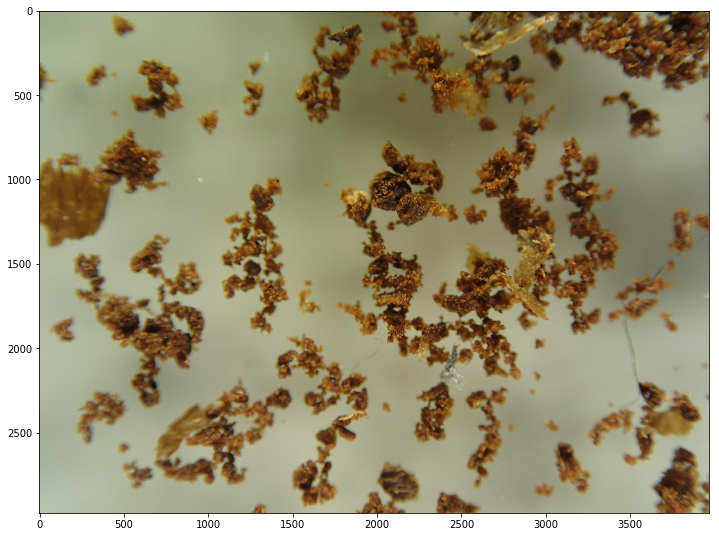

In [18]:
# plot image
plt.imshow(jpg)
plt.show()

<div class="alert alert-block alert-success">
<b>Loading the image from COS into a numpy.ndarray matrix object concludes the preparation for image processing with openCV</b>
</div>

<a id='3'></a>
## 3. The CoffeeGrindSieve

The idea of the CoffeeGrindSieve is to take an image of the coffee grind, identify the coffee grind particles, count these and to measure their size. The final result shall be a histogram representing the distribution of the size of the particles. The distribution will be characterized in terms of mean, median and variance, indicating the size and uniformity of the coffee grind particles for a particular mill and coarseness setting.

The first part of the pipeline will identify the pixels representing coffee grind:
- convert rgb image to graylevel using high contrast rgb channel
- flatten the background to obtain uniform lightning conditions using the MM tophat transform
- regard the graylevels of the image as levels of a Digital Elevation Model (DEM) with black representing valleys and white peaks
- convert to binary (BW) image by thresholding, with white pixels identifying coffee grind

The second part of the pipeline obtains markers identifying the individual particles of the coffee grind:
- use the MM geodesic distance transform of the BW image to obtain a measure of particle size
- use the MM tophat transform on the geodesic distance transform to define coffee grind particle centers

Finally, the pixels belonging to the individual coffee grind particles are identified and their size measured:
- use the MM watershed transform to grow the markers (obtained in step 2) within the boundaries of the pixels identifying coffee grind (obtained in step 1)
- to prevent neighboring markers from growing into each other, the watershed builds up seperating walls
- calculate the size of each coffee grind particle in terms of number of pixels

Starting from a crude image of coffee grind taken under a low magnification microscope some practical problems will be encountered requiring additional steps. These will be discussed in the upcoming sections. 

The next cell defines a little helper function to obtian basic information on the images created in subsequent steps


In [19]:
def imgStats(img):
    print("Image stats: ", "min:", img.min(), " max:", img.max(), " mean:", img.mean(), " median:", np.median(img), " Type:", img.dtype)

<a id='3.1'></a>
### 3.1. Fundamental MM operations

Mathematical Morphology was initally designed to work with sets of pixels in binary (black and white, BW) images. Foreground pixels are coded as 1's and plotted in white, background pixels are coded as 0's and plotted in black. Groups of adjacent foreground pixels are called 'connected components'. Most MM image transforms are calculated by sliding a small binary image, the 'structural element', across the image, carrying out some operation on the two sets of pixels of the 'strel' and the image.

<div class="alert alert-block alert-info">
<li>A <b>connected component</b> is a group of pixels touching each other</li>
</div>

<div class="alert alert-block alert-info">
<li>The <b>fundamental MM operations</b> are <b>erosion</b> and <b>dilation</b></li>
<li>A MM <b>erosion</b> removes pixels from the border of connected component</li>
<li>A MM <b>dilation</b> adds pixels at the border of a connected component</li>
</div>

The amount of pixels added is determined by the size and form of the structuring element (see plot below)

<div class="alert alert-block alert-info">
<li>A <b>opening</b> is an erosion followed by a dilation. It removes components smaller than the strel</li>
<li>A <b>closing</b> is a dilation followed by an erosion. It fills holes smaller than the strel</li>
</div>

Also, an opening removes structures smaller than the strel, while a closing fills notches at the border of a connected component.

<div class="alert alert-block alert-warning">
Details on the MM set mechanics involved are beyond the scope of this notebook, but many good resources can easily be found on the web.
</div>

The plots generated by the following code cell demonstrate the effects of these MM operations. Details on the commands used are given in the upcoming sections.

[[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]


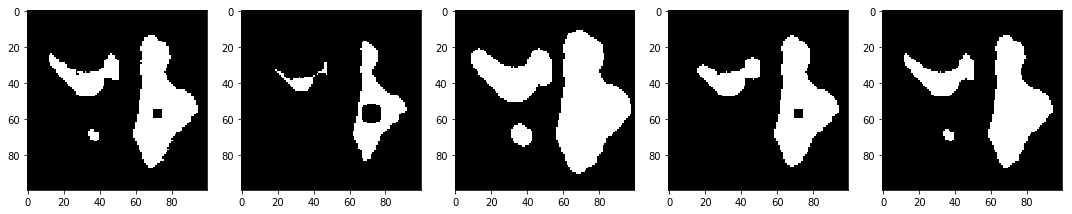

In [20]:
# Select a small part of the sample image and convert it to binary. 
orig = jpg[1340:1440,1285:1385,2]
orig = np.uint8(orig>96)
# Insert a little whole
orig[55:60,70:75] = 0

# Create a structuring element of size 7 shaped like a circle
t=7
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
# The structural element is a binary t*t matrix
print(strel)

# Calculate basic MM operations
erode = cv2.morphologyEx(orig, cv2.MORPH_ERODE, strel)
dilate = cv2.morphologyEx(orig, cv2.MORPH_DILATE, strel)
opening = cv2.morphologyEx(orig, cv2.MORPH_OPEN, strel)
closing = cv2.morphologyEx(orig, cv2.MORPH_CLOSE, strel)

# Create plot of results of above MM operations
mpl.rcParams['figure.figsize'] = [15,3]
plt.subplot(1,5,1); plt.imshow(orig,cmap= 'gray')
plt.subplot(1,5,2); plt.imshow(erode,cmap = 'gray')
plt.subplot(1,5,3); plt.imshow(dilate,cmap = 'gray')
plt.subplot(1,5,4); plt.imshow(opening,cmap = 'gray')
plt.subplot(1,5,5); plt.imshow(closing,cmap = 'gray')
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize


*From left to right: Original, Erosion, Dilation, Opening, Closing.* 

The generalizations of these fundamental operations to gray level images will be used in this notebook in several places, as well as more sophisticated MM operations including the geodesic distance transform, the local maxima and the watershed transform.

The next section covers conversion from jpg's rgb format to graylevel, and selecting a method that produces a result suitable for further processing of the coffee grind particles.

<a id='3.2'></a>
### 3.2. Convert rgb to grayscale
Several options can be used to convert from the three rgb channels to graylevel.

<div class="alert alert-block alert-info">
<li>The openCV standard method 'RGB2GRAY' calculates the graylevel as Y = 0.299\*r + 0.587\*g + 0.114\*b.</li>
</div>

Another common approach is to convert from rgb to HSV (hue, saturation, intensity) colorspace and e.g. pick the intensity channel. Here the image is split into the r,g and b channels.

The following code cell 
- splits the rgb image into its b,g,and r channels (returned in this order by openCV's 'split' method) 
- uses 'subplot' to show the b,g,r channels in a grid of one row and three cols ('subplot(nRows,nCols,curNo)')
- adapts the figure size by setting 'rcParams'
- instructs 'imshow' to use a 'gray' color map to interprete the data
- sets the dynamic range of graylevels for 'imshow' to the full 8 bit range of a graylevel jpg image


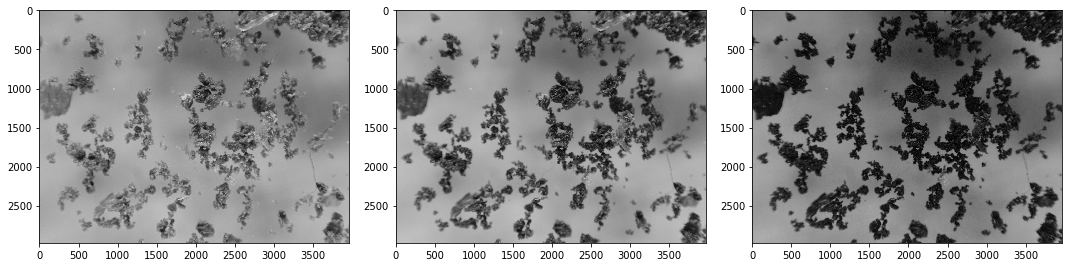

Image stats:  min: 0  max: 188  mean: 97.7282447246  median: 112.0  Type: uint8


In [21]:
# use openCV's split method
b,g,r = cv2.split(jpg)

# use subplots to show the three color channels
mpl.rcParams['figure.figsize'] = [15,10]
plt.subplot(1,3,1); plt.imshow(b,cmap= 'gray', vmin=0, vmax=255)
plt.subplot(1,3,2); plt.imshow(g,cmap = 'gray', vmin=0, vmax=255)
plt.subplot(1,3,3); plt.imshow(r,cmap = 'gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

imgStats(r)

Inspection of the separated rgb channels show that
- the blue channel is low contrast
- the green shows better contrast but in places exhibits coffee grind patches brighter than the background (e.g. top right)
- the red channel is high contrast and the coffee grind darker than the surrounding background throughout, but background lightning is uneven

The red channel is selected for further processing. The image is inverted and graylevels adjusted such that background pixels are dark and coffee grind particles bright.

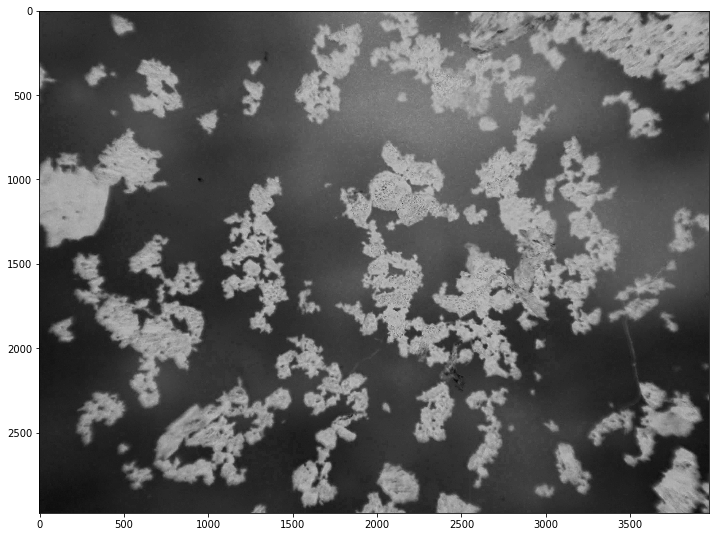

Image stats:  min: 0  max: 188  mean: 90.2717552754  median: 76.0  Type: uint8


In [22]:
# select the red channel for further processing
gray = r
# invert
gray = 255-gray
# adjust graylevels such that the darkest pixel becomes black
gray = gray-gray.min()

plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()
imgStats(gray)


Visual image inspection reveals some properties that need attention. Among these:

- non-uniform background
- grind particles touching or partly overlaying each other
- reduced sharpness and contrast towards the edges
- some artifacts

The first two will be addressed in dedicated sections below. Side effects from the two others will be ignored for the purpose of this notebook.
<div class="alert alert-block alert-warning">
Although openCV is implemented in C++ some operations take considerable time on large images. Thus the sample image is scaled down for faster processing.<br> 
Size dependent parameters in subsequent operations are formulated in terms of this 'downScale' variable, so this cell is the central point to adjust the overall scaling. 
</div>

In [23]:
# downscale image by a factor downScale
downScale = 4
gray = cv2.resize(gray, None, fx=1/downScale, fy=1/downScale, interpolation = cv2.INTER_LINEAR)

print(gray.shape, gray.size, gray.dtype)
imgStats(gray)

(744, 992) 738048 uint8
Image stats:  min: 2  max: 188  mean: 90.3779523825  median: 76.0  Type: uint8


Before proceeding the raw grayscale image is saved to COS

In [24]:
# Write image to COS
cgsWriteImage(cgsClient, cgsBucket, 'CoffeeGrind-Gray.jpg', gray)

cgsWriteImage: 
	ucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-Gray.jpg 
	ArraySize=738048 (744, 992) nRawSize=0



<a id='3.3'></a>
### 3.3. The grayscale image as digital elevation model (DEM)

The graylevels of an image can be regarded as levels of a digital elevation model. This notion is at the center of the extension of MM operations from BW to gray level images: The DEM is sliced into a stack of BW images along contour lines, then the MM operation is applied to these individually and the resulting slices are restacked. 

The next cell presents a convenience function for a 3D DEM plot of a grayscale image, with three input parameters
- img: a grayscale image
- plotScale: a scaling parameter for the plot
- plotElev: the elevation of the viewing angle relative to the base plane.

<div class="alert alert-block alert-warning">
The actual 3D plot is generated using python's plot_surface method in matplotlib. This is the one slowest operation in this notebook.
</div>

In [25]:
def cgsPlot3d(img, plotScale=1, plotElev=75):   
    # set figure size
    fig = plt.figure(figsize = (20,20))
    # downscale image to speed up plotting
    ims = cv2.resize(img, None, fx=1/plotScale, fy=1/plotScale, interpolation = cv2.INTER_LINEAR)
    # initialize 3d plot
    ax = fig.add_subplot(111, projection='3d')
    # set viewing angle
    ax.view_init(elev=plotElev)
    # create a xy grid along the size of the image
    xx, yy = np.mgrid[0:ims.shape[0], 0:ims.shape[1]]
    # construct the 3d plot on the 2D grid with z coords the gray levels
    ax.plot_surface(xx, yy, ims, rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
    plt.show()

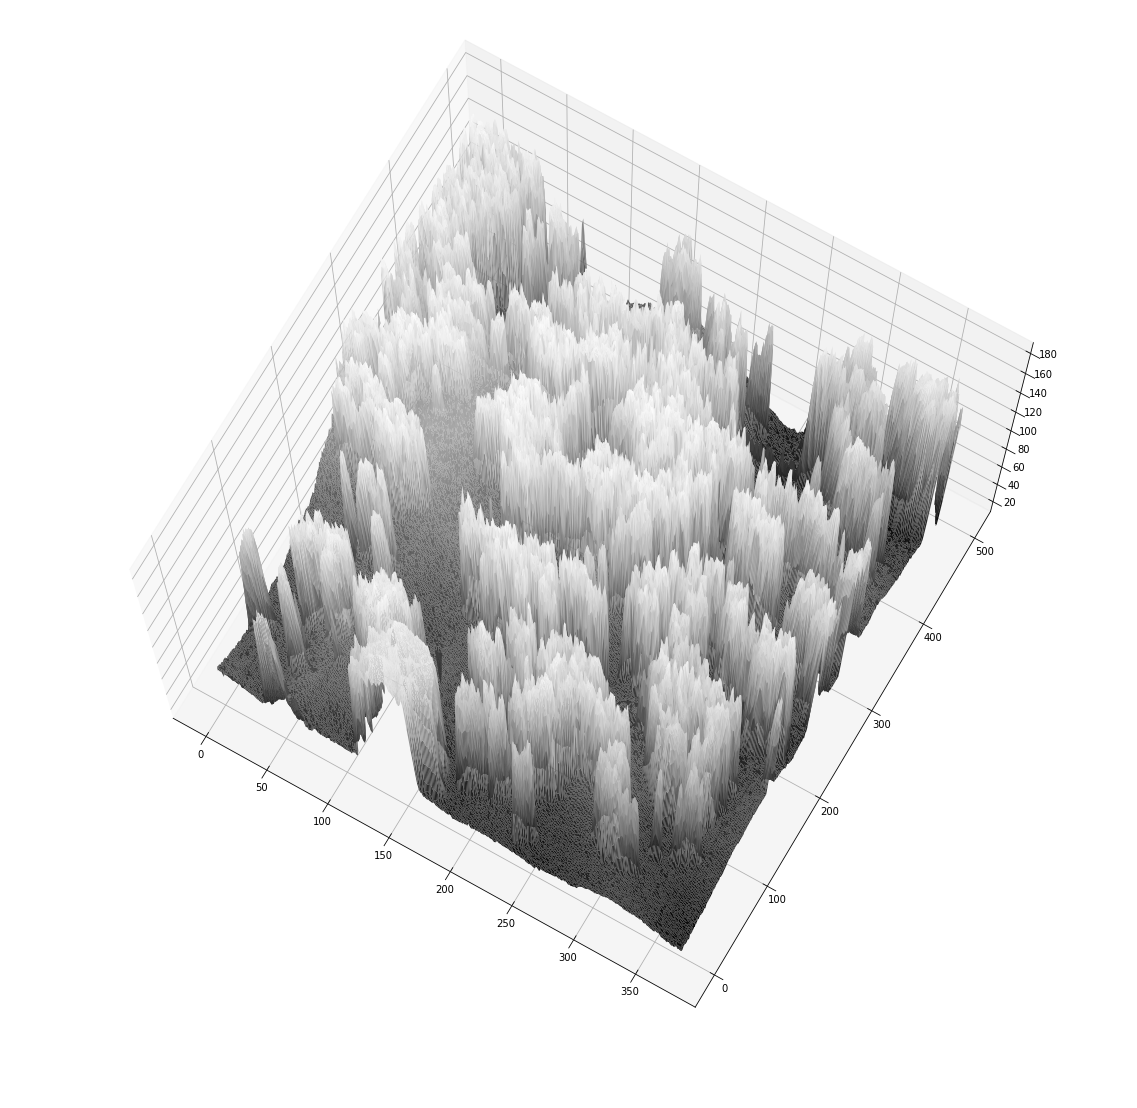

In [26]:
# plot inverted sample image (background black, coffee grind white)
cgsPlot3d(gray, plotScale=2, plotElev=75)

<a id='3.4'></a>
### 3.4. Initial image cleaning

Initial image cleaning, as all other operations in this notebook, are carried out with the grayscale image as a DEM in mind. At this stage image manipulation is kept to a minimum to preserve any information while removing technical artifacts.

<div class="alert alert-block alert-info">
<li>The openCV 'medianBlur' operation replaces each pixel with the median of it and its surroundings in an area of size 'h'. </li>
</div>

As opposed to smoothing by e.g. taking the mean, the median better preserves edges, critical in this project to identify the grind particles. Yet the operation will remove any small spikes that may result from bad pixels or lightning reflections during imaging.

<div class="alert alert-block alert-warning">
Several code cells below are headed by single character parameters that are referenced in subsequent MM methods. These may be adjusted to obtain modified results. Transformed variants of the original image are stored in dedicated variables for further reference.
</div>

The grayscale range used for plotting is explicitely set to full range for better comparison of MM operation results. As a side effect this results in low contrast for visual perception, but could easily be mitigated by setting the black and white points.

Note, however, that the minimum graylevel has has changed  from 0 in the (inverted and blackpoint adjusted) r channel of the original, to 4 in the downsized, and now to 16 in the median blurred image. This points to the existence of some small dark areas ('deep valleys' in terms of a DEM) that were smeared out by the above operations. 


Image stats:  min: 11  max: 188  mean: 90.3862445261  median: 76.0  Type: uint8


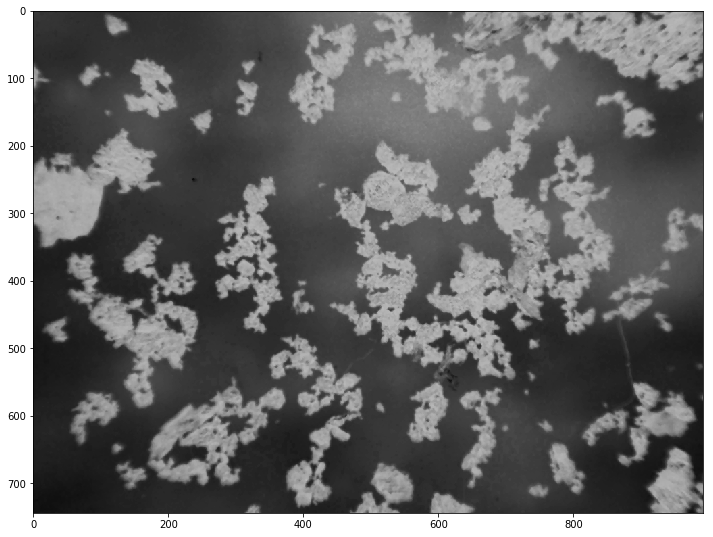

In [27]:
# Edge preserving smoothing
h = 3
smooth = cv2.medianBlur(gray, h)
smooth = np.uint8(smooth)
imgStats(smooth)
plt.imshow(smooth, cmap='gray', vmin=0, vmax=255)
plt.show()


<a id='3.5'></a>
### 3.5. Flatten non-uniform lightning of background

The straight forward method to identify pixels representing coffee grind particles would be to find a suitable graylevel threshold that seperates the dark coffee grind particles from the bright background into a BW image. As noted above the current image complicates the procedure in that the graylevels of the background in certain areas are in the same range as of the grind particles in other areas. Several options exist to deal with such a situation. Here the MM 'TopHat' operation will be used.

<div class="alert alert-block alert-info">
<li>The MM <b>TopHat</b> operation isolates and extracts <b>hills</b> in the DEM representation of a grayscale image that have a footprint smaller than a specified size.</li>
<li>This is accomplished by sliding a <b>structuring element</b> (strel) across the surface of the DEM and recording the gap between the center of the strel and the surface of the DEM for each pixel.</li>
</div>

With this approach the critical parameter is the size of the probing object, which needs to be bigger than the largest grind particle to be isolated later on. On the other hand the strel needs to be as small as possible to follow the uneven background lightning as close as possible. There are two variants of the TopHat operation:

<div class="alert alert-block alert-info">
<li>A MM <b>white TopHat</b>  extracts hills (bright) by sliding the strel across the DEM from below</li> 
<li>A MM <b>black TopHat</b>  extracts valleys (dark) by sliding the strel across the DEM from above</li> 
</div>

In terms of MM operations the TopHat is calculated as 
> TopHat(img,strel) = img - Opening(img,strel). 

As pointed out above, in BW images the MM Opening removes structures smaller than the strel from the outskirts of a connected component. This translates to estimating and removing hills in graylevel images. Here the MM Opening represents the image background (as opposed to coffee grind particles).

In terms of signal processing the MM Opening and TopHat transforms can be loosely regarded as the low and high frequency components of an image, with the size of the strel a measure for the cutoff frequency.

The size of the probing structural element is determined by experiment and choosen to be about 1/8th of the original image width. The image shows the MM TopHat transform. The uneven background lightning is mitigated. As a side effect coffee grind particles in the areas of uneven lightning are less pronounced. Note that the range of graylevels has changed from [16:191] to [0:159], and, in particular, that the median has dropped from 79 to 8, indicating that the background is now much closer to black.

<div class="alert alert-block alert-warning">
For a discussion of choosing the size of the strel as 1/8 of the image size see the 'discussion' section below.
</div>

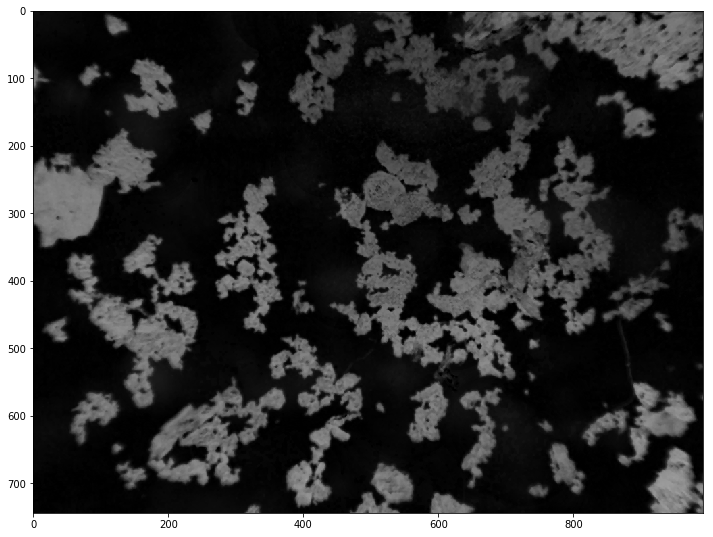

Image stats:  min: 0  max: 159  mean: 33.1733301899  median: 8.0  Type: uint8


In [28]:
# strel size experimental --> will be 512 for original size
t=np.int(512/downScale)
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
tophat = cv2.morphologyEx(smooth, cv2.MORPH_TOPHAT, strel)
plt.imshow(tophat, cmap='gray', vmin=0, vmax=255)
plt.show()

imgStats(tophat)

In [29]:
# Write image to COS
cgsWriteImage(cgsClient, cgsBucket, 'CoffeeGrind-TopHat.jpg', tophat)

cgsWriteImage: 
	ucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-TopHat.jpg 
	ArraySize=738048 (744, 992) nRawSize=0



The next plot shows a view of the TopHat as seen from below (identical to looking at the inverted image from the top). Backgroud thus is bright, and coffee grind dark.

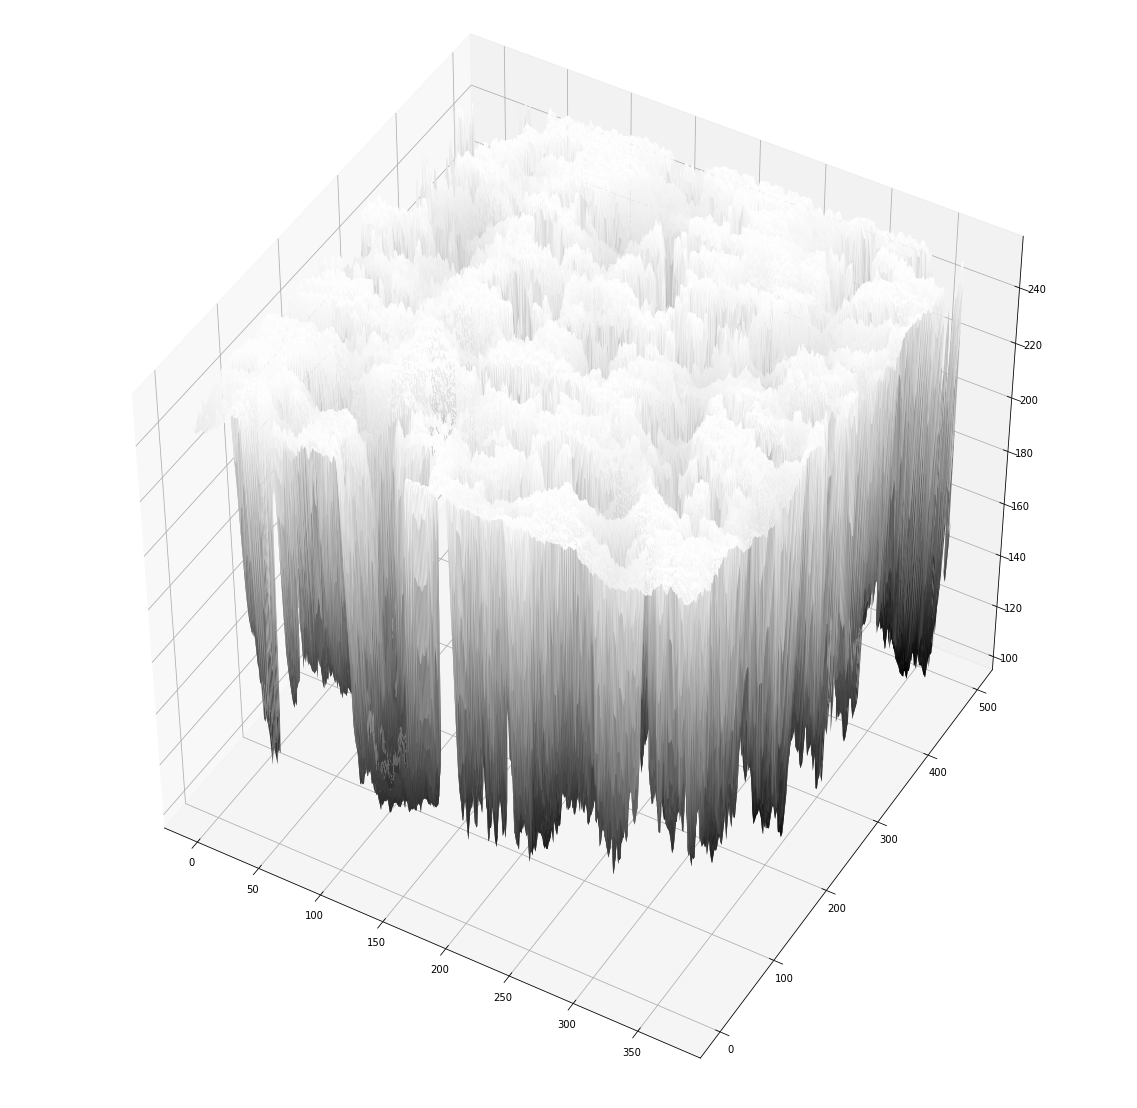

In [30]:
# plot inverted sample image (background white, coffee grind black)
cgsPlot3d(255-tophat, plotScale=2, plotElev=45)

<a id='3.6'></a>
### 3.6. Classification of pixels into coffee grind and background

With background lightning flattened the coffee grind pixels are identified by applying a threshold to the DEM of the TopHat transform. A histogram of the graylevels gives an indication of possible values for the threshold.
- Ideally the intensity histogram would show a clear seperation between background and forground (coffee grind) pixels. 
- As is evident from the TopHat plot given above, no clear seperation can be expected for the sample image.

Indeed, the flat minimum suggests possible thresholds between around 25 and 50. A not too low value on the lower side of this range is choosen to not pickup too many background pixels as coffee grind. Inevitably there is a tradeoff to miss classifying coffee grind pixels as background.

The histogram of graylevels is calculated using openCV's 'calcHist' method. The plot zooms into the relevant section for determination of the threshold.

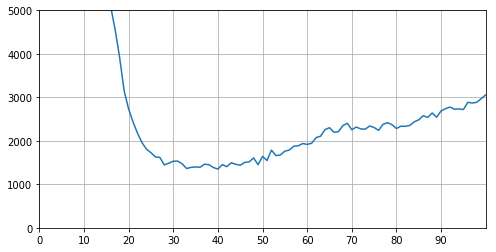

In [31]:
# Calc intensity histogram of tophat for threshold estimation
hist = cv2.calcHist([tophat],[0],None,[256],[0,256])
mpl.rcParams['figure.figsize']=[8,4]
plt.plot(hist); plt.grid()
plt.xticks(np.arange(0, 100, step=10))
plt.xlim(0,100); plt.ylim(0,5000)
plt.show()
mpl.rcParams['figure.figsize']=cgsDefPlotSize

The three plots below show the results of pixel classification for three different thresholds (28, 32 and 48). As expected lower threshold values tend to classify more pixels as coffee grind, visible particularly in those areas where uneven background lightning was corrected for. 

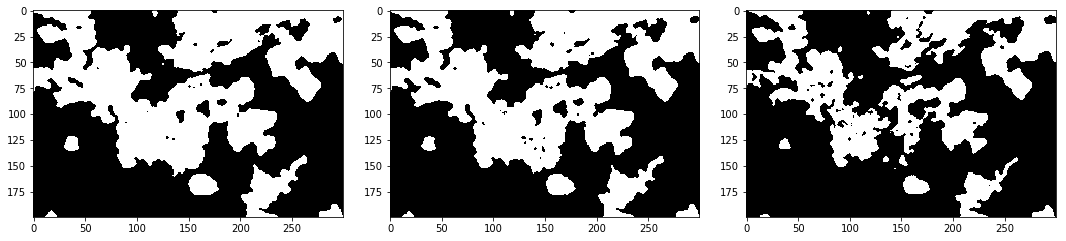

In [32]:
# convert to BW. Threshold experimental
bw1 = cv2.threshold(tophat,28, 255, cv2.THRESH_BINARY)[1]
bw2 = cv2.threshold(tophat,32, 255, cv2.THRESH_BINARY)[1]
bw3 = cv2.threshold(tophat,48, 255, cv2.THRESH_BINARY)[1]

# use subplots to show three threshold values
mpl.rcParams['figure.figsize'] = [15,10]
plt.subplot(1,3,1); plt.imshow(bw1[0:200,500:800],cmap = 'gray')
plt.subplot(1,3,2); plt.imshow(bw2[0:200,500:800],cmap = 'gray')
plt.subplot(1,3,3); plt.imshow(bw3[0:200,500:800],cmap = 'gray')
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

*From left to right: Threshold = 28, 32, 48* 

A threshold value of 32 is choosen for further processing. For remarks on this somewhat arbitrary value see the section 'discussion' below.

In [33]:
# Classify into background and coffee grind pixels
b = 32
bw = cv2.threshold(tophat,b, 255, cv2.THRESH_BINARY)[1]

<a id='3.7'></a>
### 3.7. Final classification mask

The BW image obtained is cleaned by removing very small coffee grind particles and filling very small holes. The MM methods used for this purpose are 'opening' and 'closing' introduced in section 3.1. To review, 

<div class="alert alert-block alert-info">
<li>A MM <b>opening</b> first removes pixels from the border and then adds back pixels to the shrinked object. This removes small isolated patches and small structures at the edges.</li>
<li>A MM <b>closing</b> first grows an object and then shrinks the result, thereby filling small holes and notches along the circumference.</li>
</div>

The size of the structures affected is determined by the size of the structuring element (similar to the TopHat transform). Again there is a trade off between removing potential artifacts introduced by the classification and retaining detail that matters.

In [34]:
# fill small holes
c=5
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(c,c))
bwc = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, strel)

In [35]:
# remove small particles
o=5
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(o,o))
bwco = cv2.morphologyEx(bwc, cv2.MORPH_OPEN, strel)

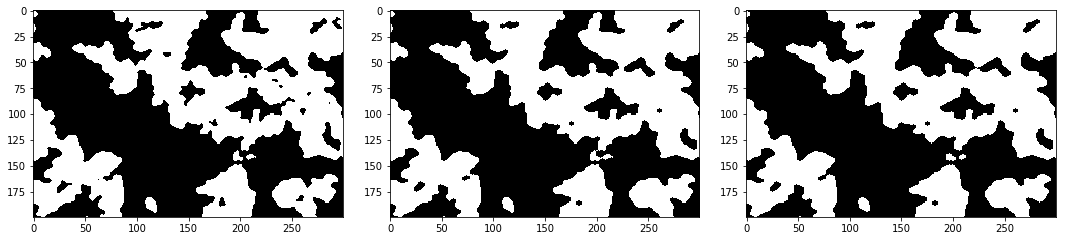

In [36]:
# Show effects of MM operations 'opening' and subsequent 'closing'
mpl.rcParams['figure.figsize'] = [15,10]
plt.subplot(1,3,1); plt.imshow(bw[400:600,400:700],cmap = 'gray')
plt.subplot(1,3,2); plt.imshow(bwc[400:600,400:700],cmap = 'gray')
plt.subplot(1,3,3); plt.imshow(bwco[400:600,400:700],cmap = 'gray')
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

*From left to right: Original, Closing, Closing+Opening* 

An opening of size five followed by a closing of the same size is used to obtain a cleaned final classification mask.<br>The code in the next cell calculates the classification mask as a binary matrix and applies it to the TopHat transform, visualizing the coffee grind particles above the background.

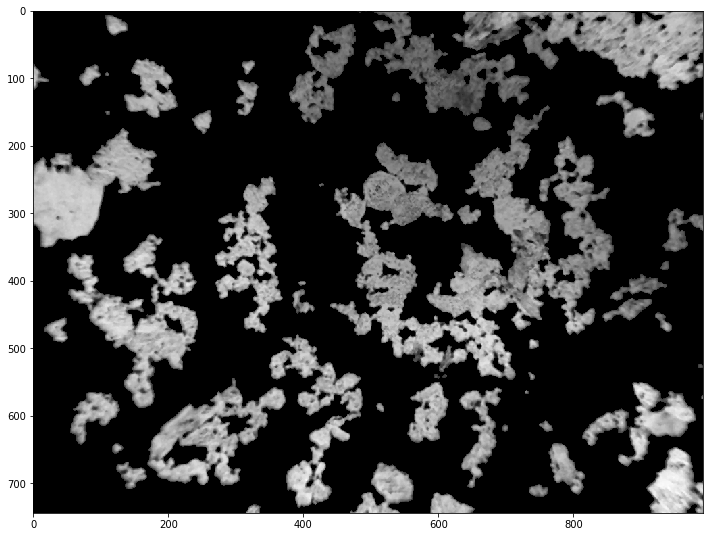

Image stats:  min: 0  max: 159  mean: 29.1380167686  median: 0.0  Type: uint8


In [37]:
# Classification mask 
cgsMask = bwco>0
cgsImg = tophat * cgsMask
plt.imshow(cgsImg, cmap='gray')
plt.show()
imgStats(cgsImg)

In [38]:
# Write image to COS
cgsWriteImage(cgsClient, cgsBucket, 'CoffeeGrind-Mask.jpg', cgsImg)

cgsWriteImage: 
	ucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-Mask.jpg 
	ArraySize=738048 (744, 992) nRawSize=0



<div class="alert alert-block alert-success">
<b>This step concludes the classification of pixels into coffee grind and background. </b>
</div>

<a id='3.8'></a>
### 3.8. Identification of  coffee grind particles

Ideally the next step would be to count the number of isolated white areas in the classification mask and to determine their size. Due to a lot of overlap of coffee grind particles these need to be seperated first. One method to do so is to cut the overlapping areas along constrictions, that is, along paths across narrowing cross-sections. Constrictions are identified by a local minimum of the distance from one side of a lump of coffee grind particles to the other. The MM 'geodesic distance transform' is often used as a starting point to handle distance related problems. 

<div class="alert alert-block alert-info">
<li>The MM <b>geodesic distance transform</b> calculates, for every foreground pixel, the distance to the nearest background pixel. 
</div>

Interpreting the result as a DEM, the elevation increases towards the center of foreground objects, with the center itself a local peak. Constrictions are identified by local minima (saddle points) along the DEM's ridges.

The following plot shows the geodesic distance transform for the classification mask calculated in the previous step. The parameters to the distance transform determine the algorithm to calculate the distance from the nearest background pixel. The elevation is transformed with a square root to visually enhance areas of low geodesic distance, that is, pixels near the edge of coffee grind particles.

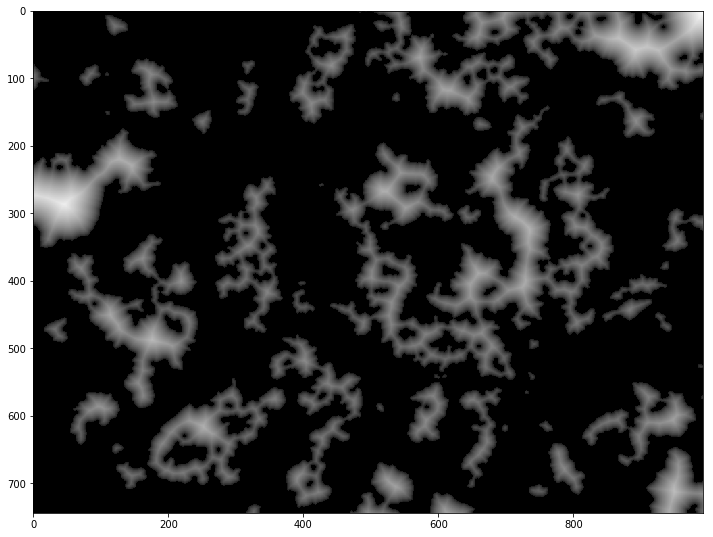

Image stats:  min: 0.0  max: 255.0  mean: 11.613  median: 0.0  Type: float32


In [39]:
# Geodesic distance transform
msk = np.uint8(cgsMask)
dt = cv2.distanceTransform(msk, distanceType=cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)
plt.imshow(np.sqrt(dt/dt.max())*255, cmap='gray', vmin=0, vmax=255)
plt.show()
imgStats(dt/dt.max()*255)

In [40]:
# Write image to COS
cgsWriteImage(cgsClient, cgsBucket, 'CoffeeGrind-Dist.jpg', dt)

cgsWriteImage: 
	ucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-Dist.jpg 
	ArraySize=738048 (744, 992) nRawSize=0



Interpreting the distance transform as a DEM, the hills will have a slope of not higher than and predominantly around 45 deg (the DEM height increases identical to the distance from the background). A TopHat transform with an even number of pixels sized strel can be used to favorably visualize this peculiar DEM (essentially a directed gradient is measured)

[[0 1]
 [1 1]]


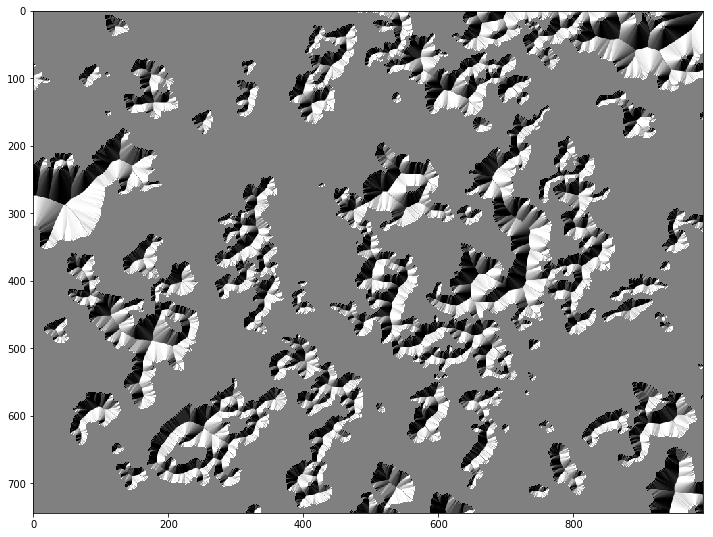

Image stats:  min: -1.0  max: 1.0  mean: 0.0021504  median: 0.0  Type: float32


In [41]:
t=2
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
print(strel)
th2 = cv2.morphologyEx(dt, cv2.MORPH_BLACKHAT, strel)
plt.imshow(th2, cmap='gray')
plt.show()
imgStats(th2)

This last image suggests that there are at least two options to isolate the coffee grind particles starting from the geodesic distance transform
- cut along constrictions (with the width of the constriction a threshold)
- identify the centers of coffee grind particles as its peaks (with the height of the peaks a threshold)

The results will be different depending on the method used and the setting of the threshold parameters. For the purpose of this notebook, the peaks in the DEM with a minimal elevation will be used to identify the centers of the coffee  grind particles. As will become evident in the next section, these peaks can be used as 'seeds' to grow the actual coffee grind particles.

<div class="alert alert-block alert-warning">
Because the MM 'Local Maxima' method is not implemented in openCV, the 'skyimage' morphology library is employed here.
</div>

<div class="alert alert-block alert-info">
<li>The MM <b>h_maxima</b> method extracts the local peaks of at least height 'h'</li>
<li>The MM <b>connectedComponents</b> method identifies, counts and marks groups of connected foreground pixels.</li>
</div>

Applied to the local maxima of the geodesic distance transformmethod this method counts the number of peaks of a given height (corresponding to number of particles of minimum size). The following code section calculates the number of peaks of size 1 to 32 in a loop and plots the results.
 
Remark: In the field of **Granulometry** this kind of 'number of objects vs. size of object constructor' relation is used to infere the size of objects in an image.

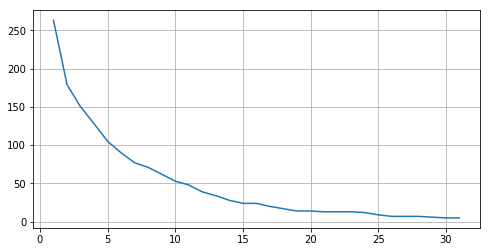

In [42]:
# Find local maxima in dt DEM
from skimage import morphology as sm

t=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
c=[]
for h in range(1,32):
    mxa = sm.h_maxima(dt,h,strel)
    n,cc = cv2.connectedComponents(np.uint8(mxa>0))  
    c.append(n)
      
mpl.rcParams['figure.figsize']=[8,4]
plt.plot(range(1,32),c)
plt.grid()
plt.show()
mpl.rcParams['figure.figsize']=cgsDefPlotSize


A minimum elevation of the peaks (local maxima) of 2 above its surroundings is selected for further processing. Again, this decision is discussed further in the section 'discussion' below. The next image shows the coffee grind with the classification mask applied and the local maxima of the distance transform indicated as black dots.

Number of coffee grind particles: 179


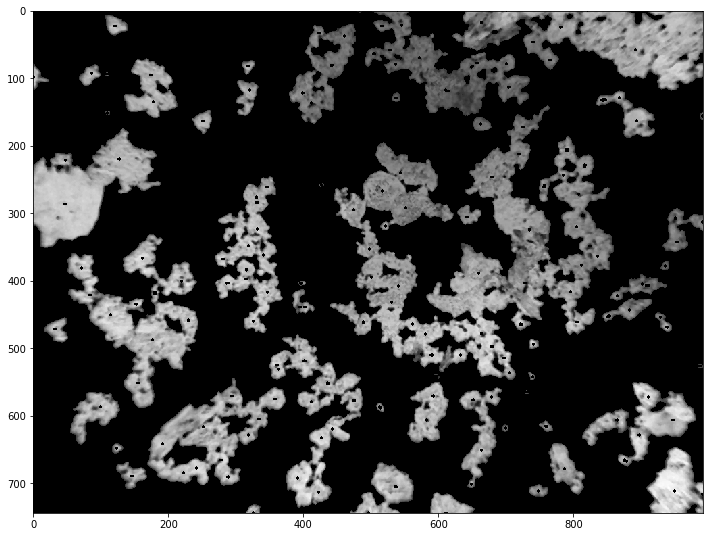

Image stats:  min: 0  max: 1  mean: 0.00433982613597  median: 0.0  Type: uint8


In [43]:
# Show local maxima found in distance transform of classification mask
t=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))

# calculate local maxima
h=2
seeds = sm.h_maxima(dt,h,strel)
seeds = np.uint8(seeds)

# count and identify local maxima as connected components
n,cc = cv2.connectedComponents(seeds)  
print("Number of coffee grind particles:", n)

# grow markers for visual clarity
t=5
strel5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
markers = cv2.morphologyEx(seeds, cv2.MORPH_DILATE, strel5)

# plot markers as black dots on top of the coffee grind
plt.imshow(cgsImg * (1-markers), cmap='gray')
plt.show()
imgStats(markers)

In [44]:
# Write image to COS
cgsWriteImage(cgsClient, cgsBucket, 'CoffeeGrind-Gray.jpg', cgsImg * (1-markers))

cgsWriteImage: 
	ucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-Gray.jpg 
	ArraySize=738048 (744, 992) nRawSize=0



<a id='3.9'></a>
### 3.9. Using the watershed transform to segment the coffe grind particles

The watershed transform is a method used in the field of image segmentation.

<div class="alert alert-block alert-info">
<li>The MM <b>watershed transform</b> segments an image by flooding the valleys and basins of its DEM</li>
</div>

- Essentially it starts from basins defined by the local minima of an image and poors water into these basins until one is about to overflow into a neighboring basin.
- To prevent overflow, walls are built up at the location where overflow would occure.
- The process ends when all basins have been filled and all walls built.

In many cases this leads to oversegmentation (each little minimum in the DEM generates one basin, that is, segment). One common strategy to mitigate oversegmentation is to identify the initial basins by explicitly providing starting points instead of automatic calculation as DEM local minima. For the segmentation of the coffee grind particles it is exactly the seeds calculated above (as local maxima of the distance transform of the coffe grind classification matrix) that are the desired watershed starting points

The following code cell
- calculates the watershed transform of the masked coffee grind image from these starting points
- segments built during watershed have their pixel's intensity value set to the segment number
- walls built during watershed are set to -1, so 1 is added to obtain a valid graylevel image range
- increases the thickness of walls for visual clarity (in fact, the actual segments are shrinked with an MM erode operation leaving a thicker wall between them)

<div class="alert alert-block alert-warning">
Remark: For some reason, the image background is listed as just another segment in the watershed transform.<br>The corresponding segment number is calculated as the most frequent graylevel value and subsequently set to zero.
</div>

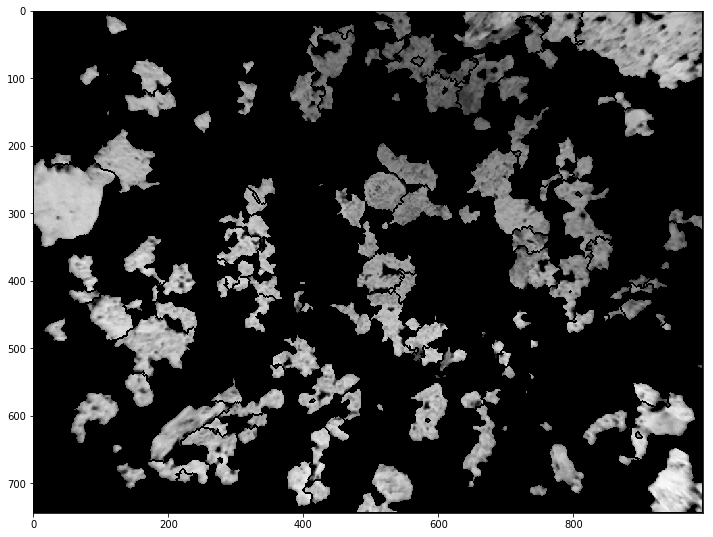

In [45]:
# must convert to rgb image for watershed
rgb = cv2.cvtColor(cgsImg, cv2.COLOR_GRAY2BGR)
# Run watershed. Walls are identifed as '-1'. 
ws = cv2.watershed(rgb,cc)+1
ws = np.uint8(ws)

# set image background to 0. don't know why background is just another segment
hist = cv2.calcHist([ws],[0],None,[256],[0,256])
idx = np.argmax(hist)
ws[ws==idx] = 0

# increase size of segmentation walls for visual clarity
t=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
wsd = cv2.morphologyEx(ws, cv2.MORPH_ERODE, strel)

# plot black segmentation walls on top of the coffee grind
cgs = (wsd>1)*cgsImg
plt.imshow(cgs, cmap='gray')
plt.show()

In [46]:
# Write image to COS
cgsWriteImage(cgsClient, cgsBucket, 'CoffeeGrind-WaterShed.jpg', cgs)

cgsWriteImage: 
	ucket=coffeegrindsieve1ebac7a11b7e40699283426d3cd518db 
	File=CoffeeGrind-WaterShed.jpg 
	ArraySize=738048 (744, 992) nRawSize=0



<div class="alert alert-block alert-success">
<b>This step concludes the segmentation of coffee grind into coffee grind particles. </b>
</div>

<a id='3.10'></a>
### 3.10. Calculate size of coffee grind particles

The only thing left to do is to calculate the size of the segmented coffee grind particles. Here a variant of the openCV 'connectedComponents' method is used that returns the size of the components in 'cc_stats'. 

In [47]:
# Final connected components
cc_n, cc_lbl, cc_stats, cc_cntr = cv2.connectedComponentsWithStats(ws, connectivity=4)
print("Number of coffee grind particles:", cc_n)

Number of coffee grind particles: 163


From a coffee brewing perspective the diameter of the coffee grind particles is the important parameter. Thus the final values are calculated as square root of the size in pixels. For absolute values in units of e.g. millimeters the area an image pixel covers in object space needs to be provided.

The following convenience method creates the histogram with suitable x and y tics as well as labels.

In [48]:
def ccHist(cc):
    m=126; k=5; n = np.uint8(m/k)
    x = np.double(range(0,m,k))
    h = np.histogram(cc, bins=x**2)
    fig = plt.figure()
    plt.bar(x[0:n]+k/2,h[0][0:n],k-1)
    plt.xticks(np.uint8(x),np.uint8(x))
    plt.grid(); plt.xlim(0,m-1)
    plt.xlabel("Mean diameter of particles [~pixels]")
    plt.ylabel("Number of particles")
    plt.show()
    

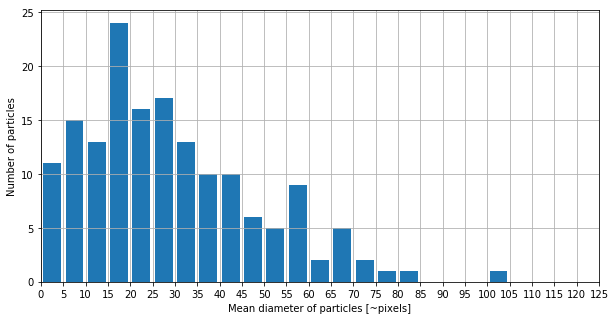

In [49]:
# Area of cc's
mpl.rcParams['figure.figsize']=[10,5]

# Extract size of connected components
cc_area = cc_stats[:,cv2.CC_STAT_AREA]

# Call histogram method defined above
ccHist(cc_area)
mpl.rcParams['figure.figsize']=cgsDefPlotSize

In [50]:
cc_diameter = np.sqrt(cc_area)
print("MeanDiameter=%d+-%d    MedianDiameter=%d IQR=%d" % 
      (np.mean(cc_diameter), np.std(cc_diameter), np.median(cc_diameter), np.percentile(cc_diameter,75)-np.percentile(cc_diameter,25)))

MeanDiameter=34+-57    MedianDiameter=26 IQR=25


<a id='4'></a>
## 4. Discussion and outlook
The image segmentation pipeline presented in this notebook has produced acceptable results. The applicability to a wider range of images remains to be investigated. In particular, several parameters have been sized to work for the example image used.

<a id='4.1'></a>
### 4.1. Critical parameters
All MM methods require a structuring element for their operation, with the size a critical parameter. Either a fixed setting or an automatic estimation is needed for a production grade pipeline. The present notebook makes manual assumptions on MM and other parameters in several places that need elaboration. Among these

- the approach to convert from color to grayscale
- the size of the structuring element for flattening the uneven lightning of the image back ground
- the graylevel threshold value to seperate coffee grind from background
- the algorithm and parameters to seperate overlapping coffee grind particles

<a id='4.2'></a>
### 4.2. Image acquisition process
For the most part the first three challenges can be eliminated by a suitable setup of the image acquistion process. Uniform lightning, optimized light color and direction, optimized image back ground, flat focal plane asf. contribute to consistent results.

The problem of segmentation of coffee grind into particles is different in that 
- the algorithm chosen (e.g. local maxima or constrictions of the distance transform) yields different results
- it is not obvious what the correct result looks like in the first place

In particular it is not obvious what constitutes a coffee grind particle in the presence of overlap or otherwise cohesive coffee grind. The amount of particle overlap should, as above, be controlled before image acquisition. The remaining ambiguity inevitably leads to some imponderability of the final result. For a series of measurements with identical parameters these amount to a calibration of the image processing pipeline. The results should be comparable but not necessarily optimal.

<a id='4.3'></a>
### 4.3. Advanced segmentation
Close inspection of the final segmentation result shows patches of coffee grind that have been seperated while others remain connected, both for no obvious reason. More work is needed to investigate this behavior. To this end several elaborate MM methods exist, including e.g. skeletons or geodesic reconstruction. These could be written based on the MM operations available in openCV, but are not readily available (yet). Another resource of morphological methods in python is the morphology library of the skyimage package.




<a id='5'></a>
## 5. Summary

The Mathematical Morphology methods in the openCV (openComputerVision) library have been successfully applied in the CoffeeGrindSieve image segmentation application. The application was developed as a python notebook residing on IBM DataScienceExperience (DSX), with data located on IBM Cloud Object Storage (COS).

The notebook covered the prerequisites to work with openCV and introduced basic morphological operations on binary and grayscale images, including erosion, dilation, opening, closing and tophat. The geodesic distance transform, its local maxima and the watershed transform were used to demonstrate image segmentation on a real world sample image. Together with the  methods presented to access data that reside on Cloud Object Storage a basic setup for tackling computer vision related tasks on Data Science Experience has been layed out.

<a id='5.1'></a>
### 5.1. References

- [Sample Image](https://github.com/at062084/CoffeeGrindSieve/CoffeeGrindSample.jpg)
- [openCV image processing documentation](https://docs.opencv.org/3.4.1/d7/dbd/group__imgproc.html)
- [skyimage documentation](http://scikit-image.org/docs/dev)
- [ibm_boto3 documentation](https://ibm.github.io/ibm-cos-sdk-python)

<a id='5.2'></a>
### 5.2. About the Author
**Thomas Strehl** is a Data Scientist and Infrastructure Architect at IBM in Austria. Strehl is a regular speaker at WDP and DSX related events and a promotor of the R Language for Statistical Computing in the big data arena. He holds a BA in 'Data Engineering, Statistics and Visual Computing'.  


Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.

